# Finloop PV segmentation

source (Huggingface): finloop/yolov8s-seg-solar-panels (aka Rzeszów model)

credits: https://blog.roboflow.com/how-to-use-yolov8-with-sam/ (Roboflow)

VI 25 with changes 15 X 25, 9 XI 25 and on

*MD*

note: a dual-use model (detection + instance segmentation)

requires OBB-versioned datasets

## libs

In [30]:
# %pip install numpy
# %pip install pandas
# %pip install ultralytics

In [31]:
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO
import torch
from os import listdir
from os.path import isfile, join

In [32]:
dev = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
dev

device(type='cuda', index=0)

## defs

### data

In [33]:
pilot = "pilotPV_panels.v1i.yolov8-obb/data.yaml"
rzeszow = "rzeszowSolar panels seg.v2i.yolov8-obb/data.yaml"
synth = 'auto_pv_to_fine_tunning.v4i.yolov8-obb/data.yaml'

In [34]:
proste_1_zdj = "rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg"

data_p = proste_1_zdj
pth = proste_1_zdj
nazwa = "proste_1_zdj"

### model

In [35]:
model_pt = "best.pt"

In [36]:
model = YOLO(model=model_pt, task="segment", verbose=True)

### segment analysis

In [37]:
def sum_pv_segments(pth, nazwa, model=model, disp_img=False, print_info=False):
    pv_area = 0
    results = model(pth, save=print_info, name=nazwa, stream=True)
    for i, res in enumerate(results):
        image = cv2.cvtColor(cv2.imread(pth), cv2.COLOR_BGR2RGB)
        image = torch.tensor(image, device=dev)
        img_w, img_h, _ = image.shape
        if print_info:
            print(i)
        if res is not None and res.masks is not None:
            for j, msk in enumerate(res.masks):
                binary_mask = torch.where(msk.data > 0.5, 1, 0)
                pv_area += binary_mask.sum().div(img_w*img_h)
                if print_info:
                    print('\t', j, binary_mask)
                if disp_img:
                    binary_mask = binary_mask.data
                    bcg_white = torch.ones_like(image)*255
                    new_image = bcg_white * (1 - binary_mask[..., torch.newaxis]) + image * binary_mask[..., torch.newaxis]
                    plt.imshow(new_image.reshape((img_w, img_h, 3)).cpu())
                    plt.title(f"Mask {j} in {pth[pth.rfind('/'):]}")
                    plt.axis('off')
                    plt.show()
        if print_info:
            print(pv_area.item())
        if disp_img:
            plt.imshow(image.cpu())
            plt.title(f"base img {pth[pth.rfind('/'):]}")
            plt.axis('off')
            plt.show()
    return pv_area

In [38]:
def sum_pv_segments_batch(imgs, nazwa, model=model, disp_img=False, print_info=False):
    pv_area = 0
    if isinstance(imgs, str):
        if "*" in imgs:
            imgs = imgs.split("*")[0]
            imgs = [join(imgs, f) for f in listdir(imgs) if isfile(join(imgs, f)) and f.endswith('jpg')]
            for i, img in enumerate(imgs):
                x = i % 10 == 0
                pv_area += sum_pv_segments(img, nazwa, model, disp_img and x, print_info)
            return pv_area
        return sum_pv_segments(imgs, nazwa, model, disp_img, print_info)
    else:
        for img in imgs:
            pv_area += sum_pv_segments(img, nazwa, model, disp_img, print_info)
    return pv_area

## segment

### numbers

jeden obraz

In [39]:
sumka = sum_pv_segments_batch(data_p, "proste_funk")
sumka


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 640x640 4 solar-panels, 24.0ms
Speed: 1.4ms preprocess, 24.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


tensor(0.0971, device='cuda:0')

podwójnie

In [40]:
sum_pv_segments_batch([data_p,data_p], "proste_funk_podwojnie")


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 640x640 4 solar-panels, 24.4ms
Speed: 2.4ms preprocess, 24.4ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 640x640 4 solar-panels, 24.0ms
Speed: 1.2ms preprocess, 24.0ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)


tensor(0.1942, device='cuda:0')

### imgs


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 640x640 4 solar-panels, 23.8ms


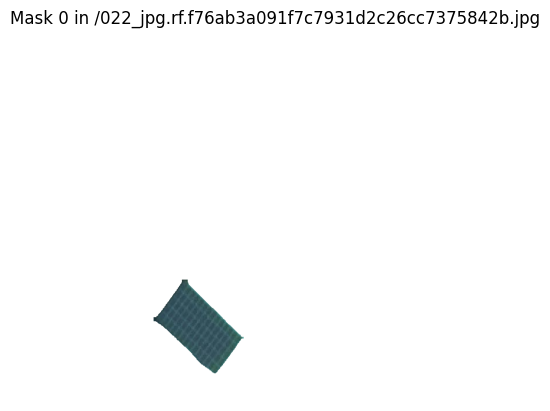

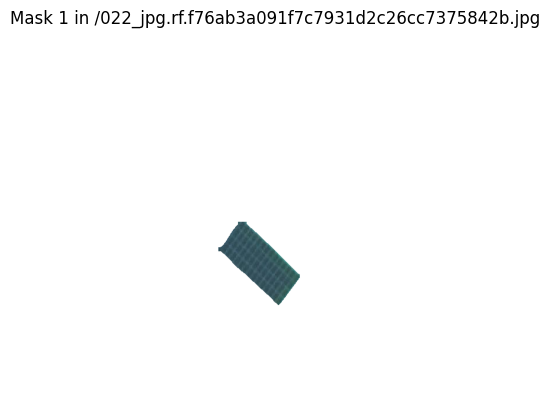

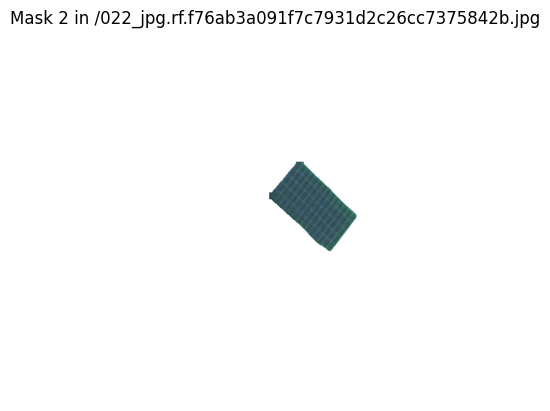

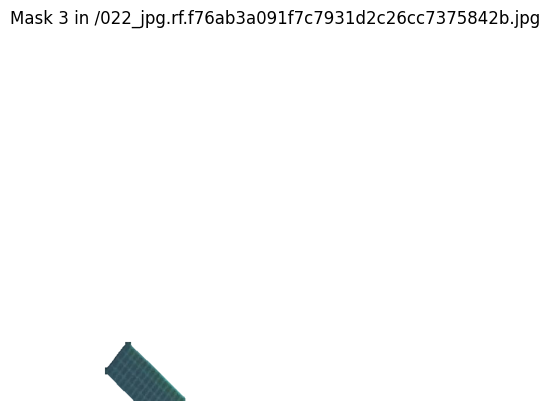

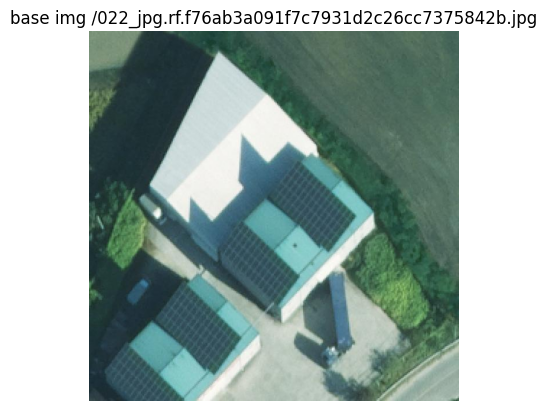

Speed: 1.6ms preprocess, 23.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


tensor(0.0971, device='cuda:0')

In [41]:
sum_pv_segments_batch(data_p, "proste_funk", disp_img=True)


image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 640x640 4 solar-panels, 20.3ms


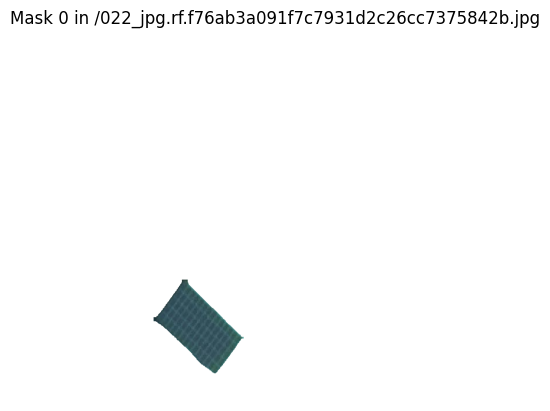

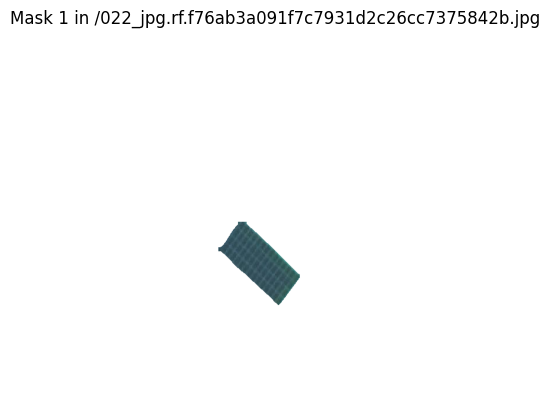

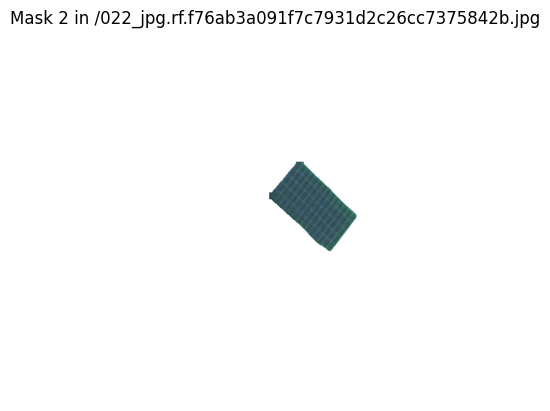

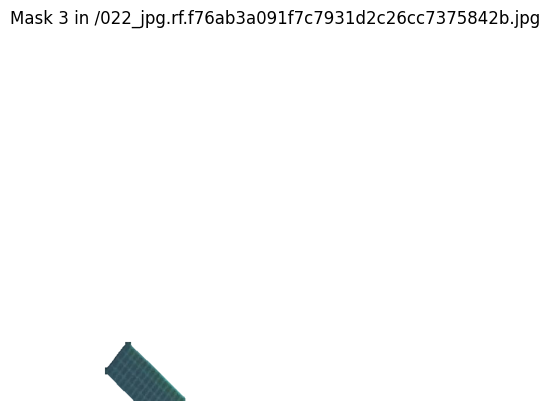

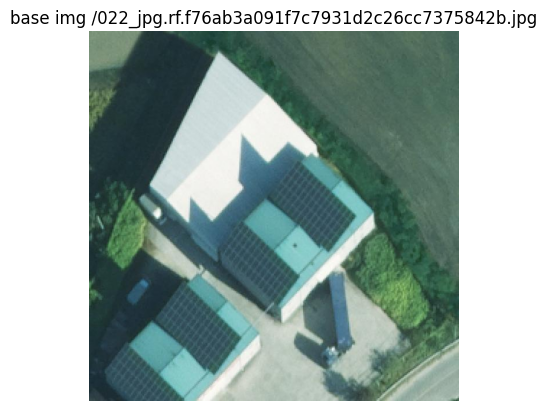

Speed: 1.6ms preprocess, 20.3ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/rzeszowSolar panels seg.v2i.yolov8-obb/test/images/022_jpg.rf.f76ab3a091f7c7931d2c26cc7375842b.jpg: 640x640 4 solar-panels, 20.1ms


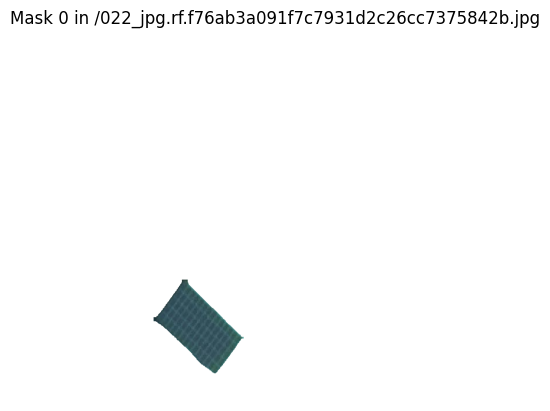

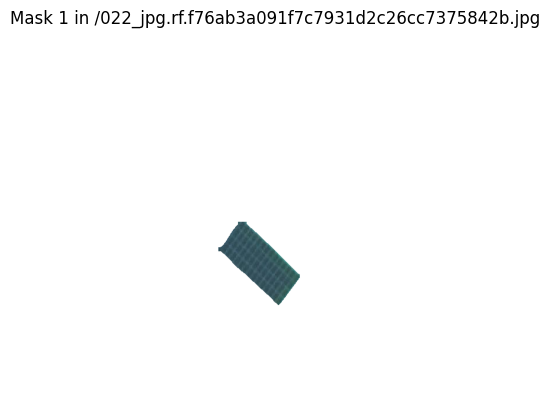

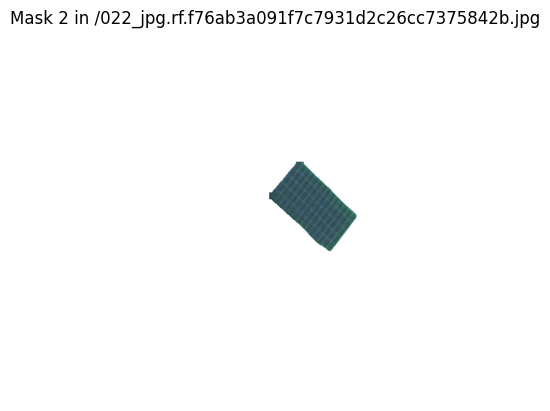

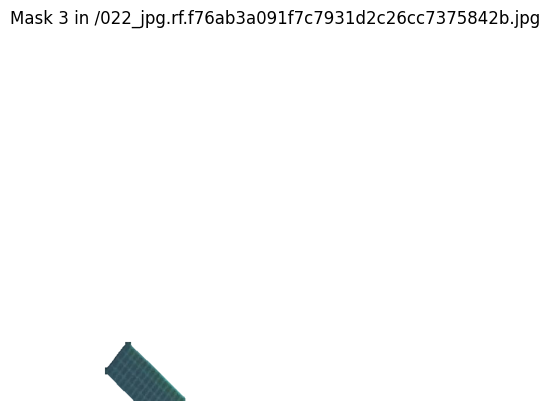

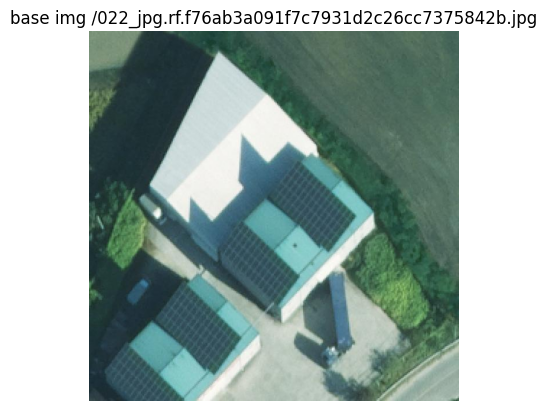

Speed: 1.3ms preprocess, 20.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


tensor(0.1942, device='cuda:0')

In [42]:
sum_pv_segments_batch([data_p,data_p], "proste_funk_podwojnie", disp_img=True)

## pilot


image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-387-_png.rf.8d9cf2f95f0bd6a3d3f4aab53d947b60.jpg: 640x640 5 solar-panels, 20.2ms


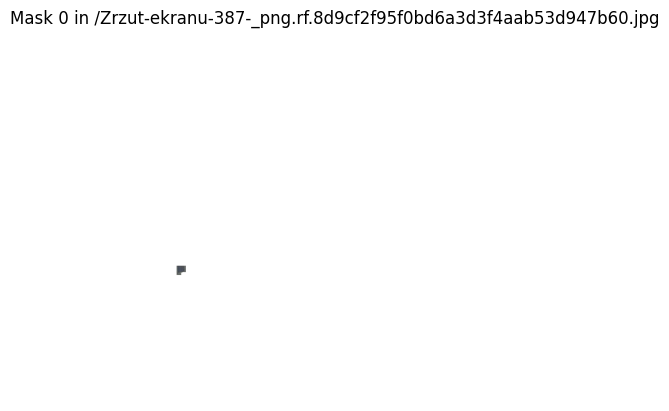

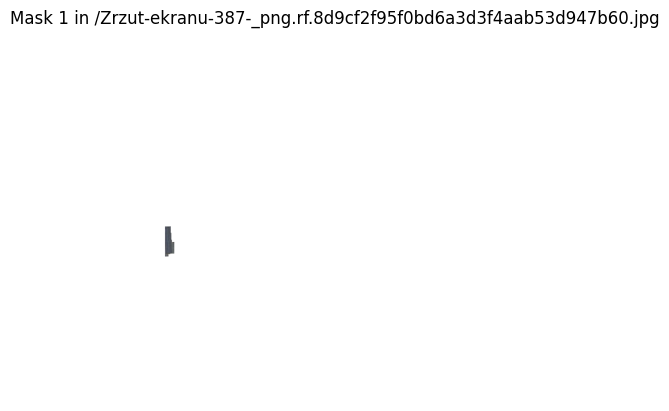

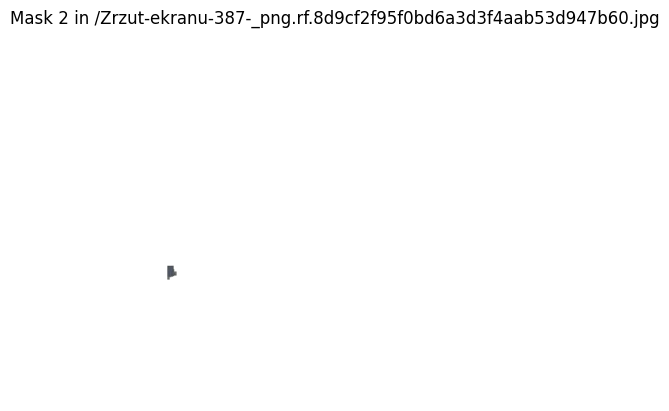

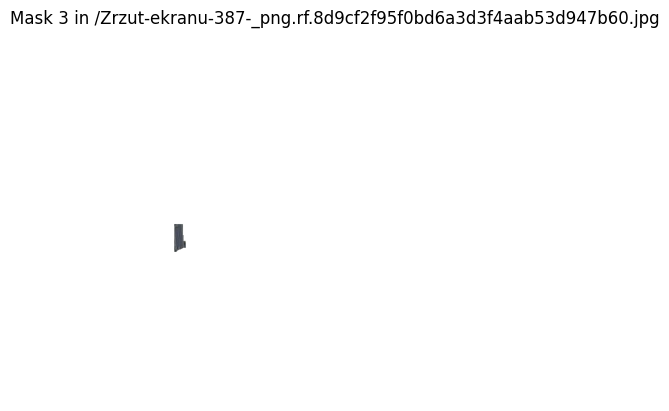

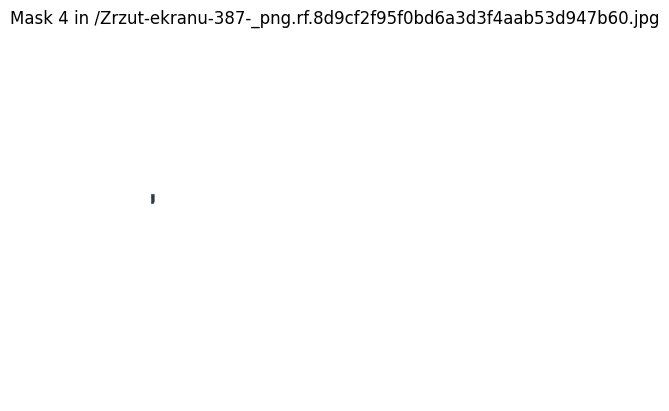

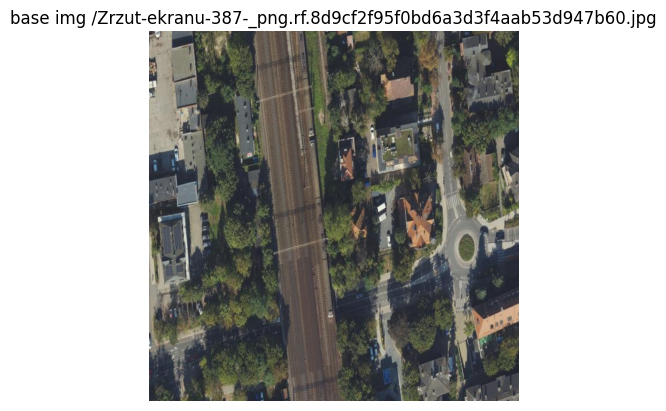

Speed: 1.5ms preprocess, 20.2ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-391-_png.rf.389014ff4ad431e6038114a377054b0a.jpg: 640x640 2 solar-panels, 20.1ms
Speed: 1.5ms preprocess, 20.1ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-313-_png.rf.8195514f57fe4ab855a7ebb3e4f57ce0.jpg: 640x640 16 solar-panels, 20.1ms
Speed: 1.3ms preprocess, 20.1ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-381-_png.rf.30e1db7981eb42605ec077c393dded26.jpg: 640x640 15 solar-panels, 20.0ms
Speed: 1.2ms preprocess, 20.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotP

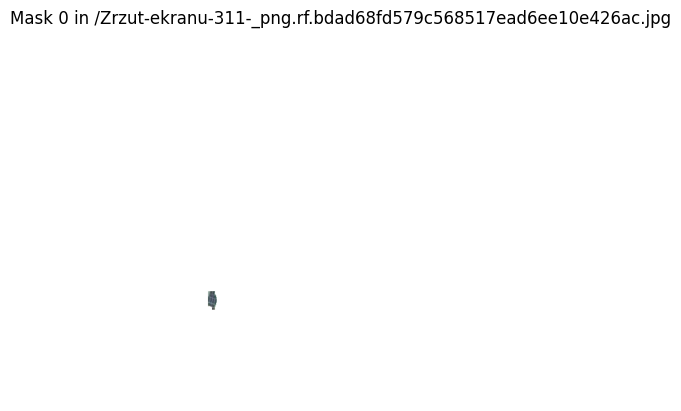

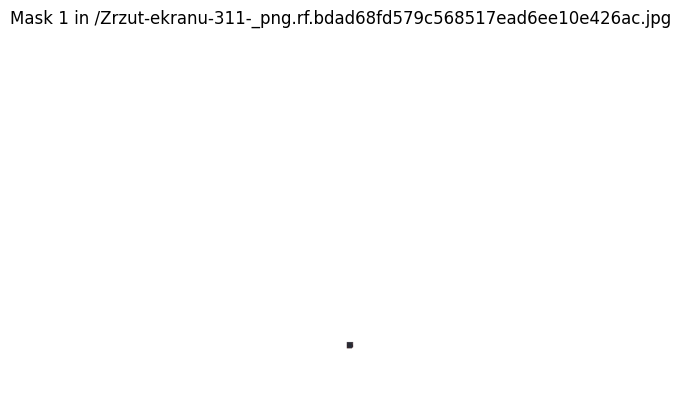

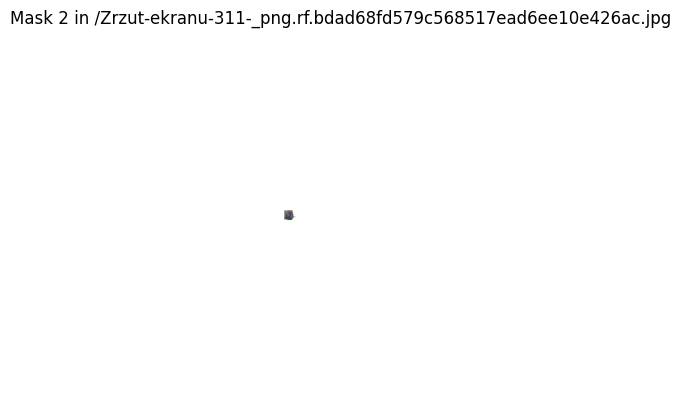

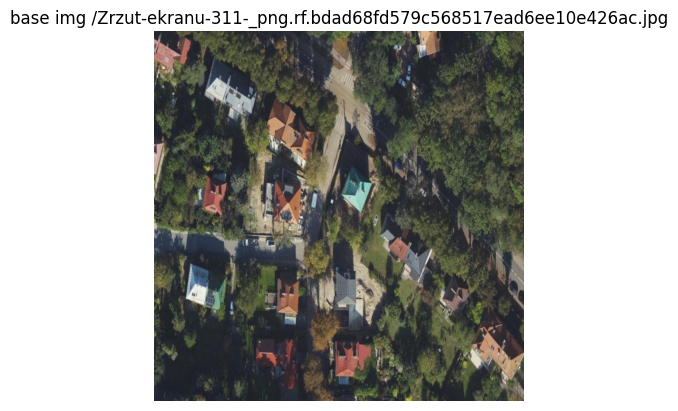

Speed: 1.2ms preprocess, 20.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-394-_png.rf.4c4348df4ca9878b4126ad4f5f88cd09.jpg: 640x640 4 solar-panels, 20.7ms
Speed: 1.5ms preprocess, 20.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-382-_png.rf.9cee819c621c7ffc7ee00afd455fcc1e.jpg: 640x640 4 solar-panels, 20.0ms
Speed: 1.2ms preprocess, 20.0ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-329-_png.rf.7f71efcf38ed4e45a0fb500c1327f462.jpg: 640x640 1 solar-panel, 20.2ms
Speed: 1.2ms preprocess, 20.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_p

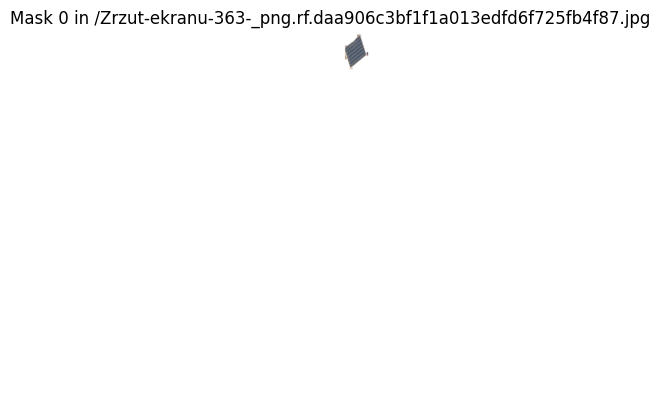

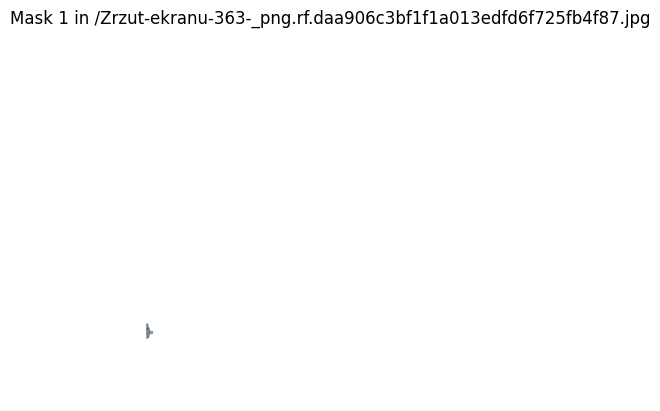

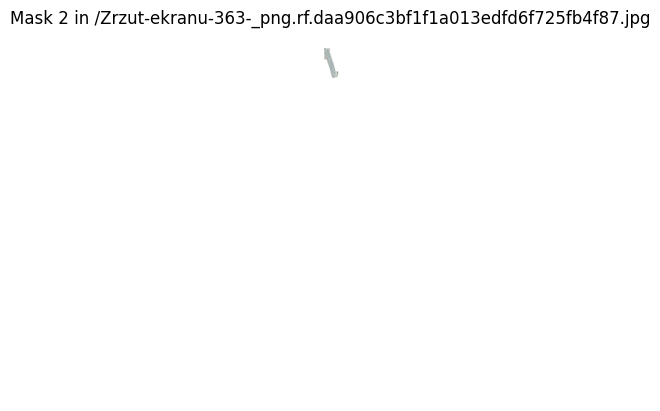

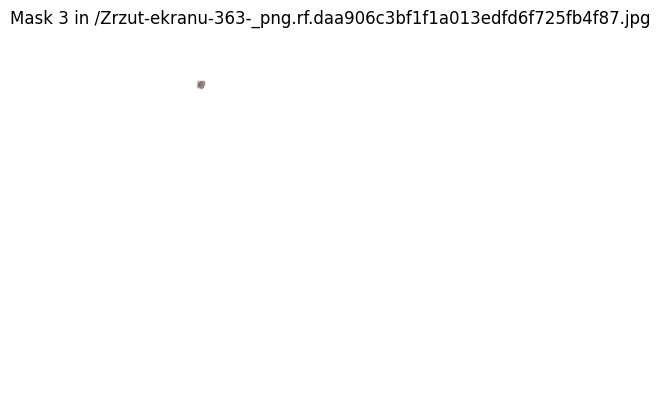

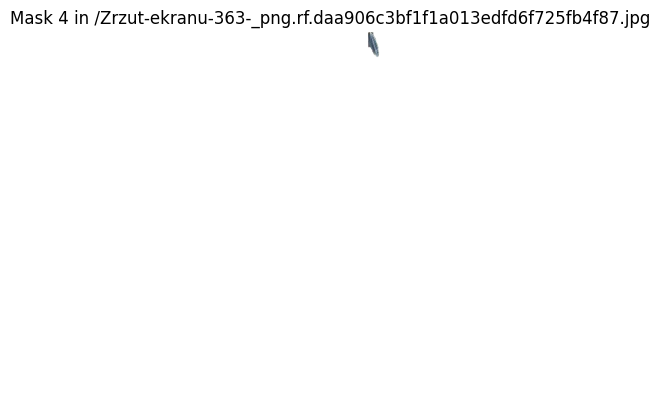

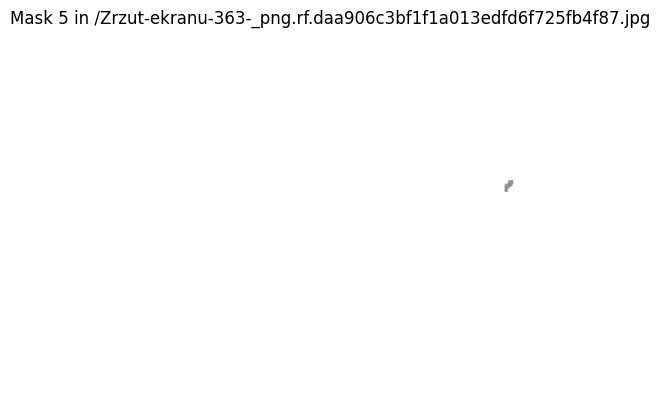

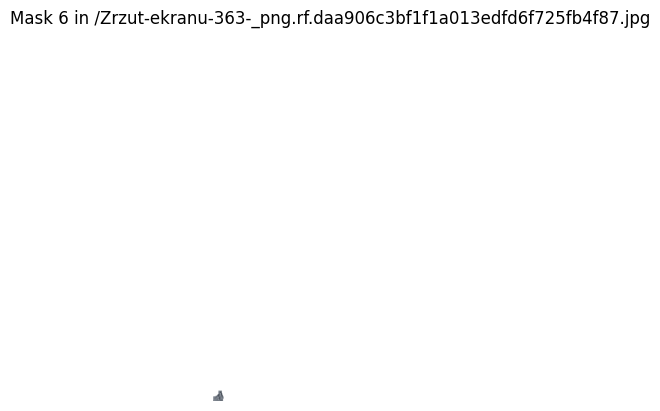

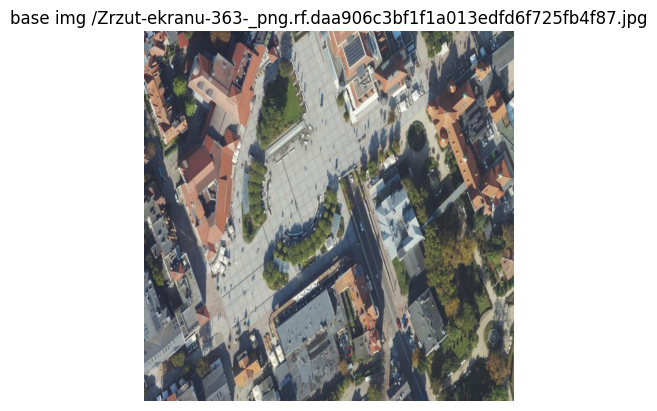

Speed: 1.2ms preprocess, 20.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-376-_png.rf.77bfde4a9f4e384ec2c370624a55de61.jpg: 640x640 4 solar-panels, 20.1ms
Speed: 1.7ms preprocess, 20.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-293-_png.rf.6501de77787921a2b0c0a3fac3ff7882.jpg: 640x640 13 solar-panels, 20.0ms
Speed: 1.2ms preprocess, 20.0ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-331-_png.rf.333f08019387488712fe99b26eb33a72.jpg: 640x640 1 solar-panel, 20.1ms
Speed: 1.3ms preprocess, 20.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_

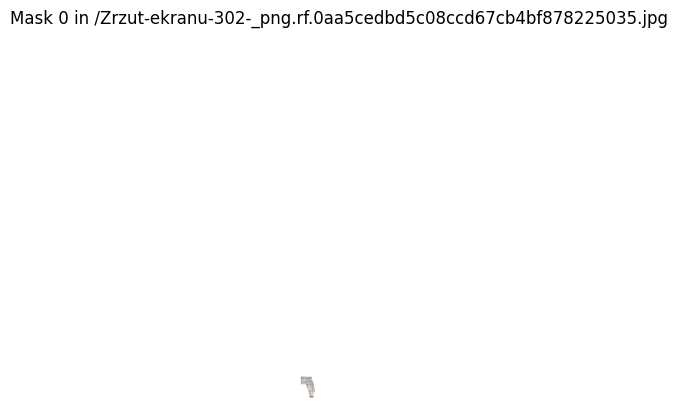

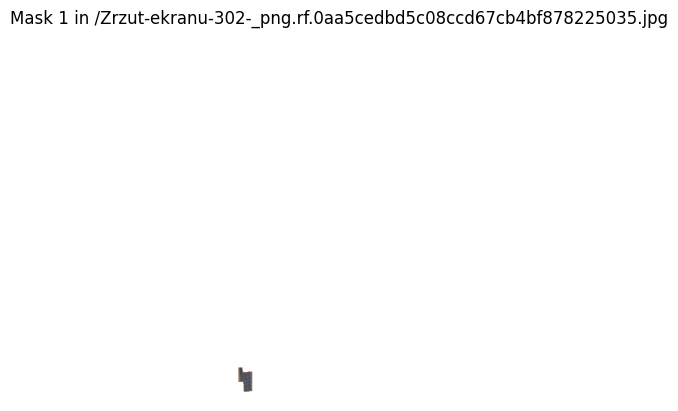

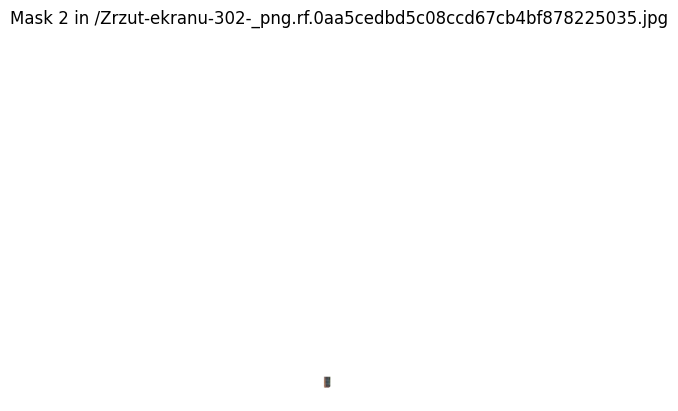

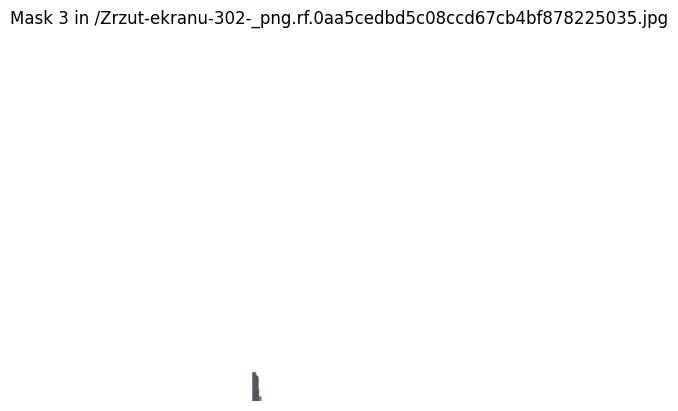

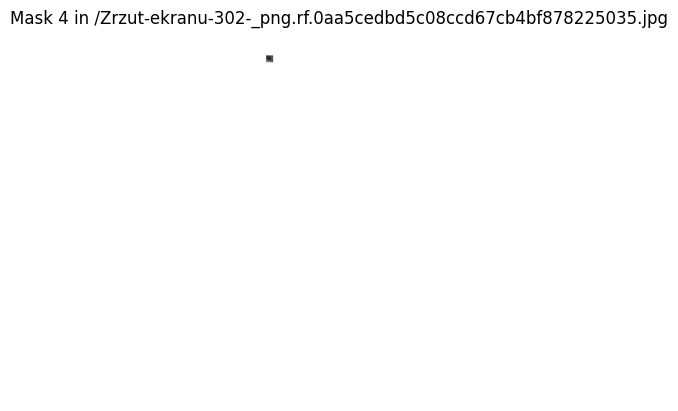

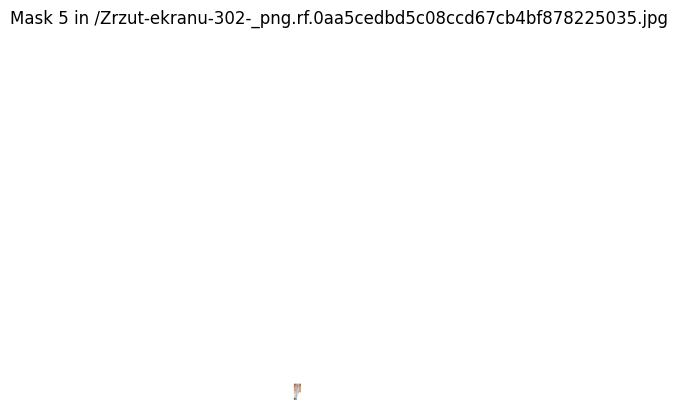

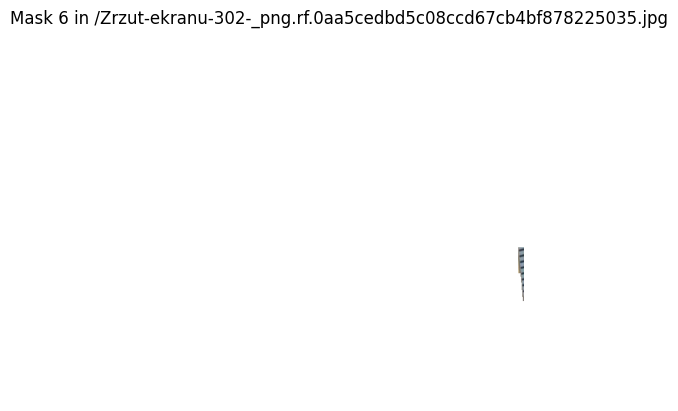

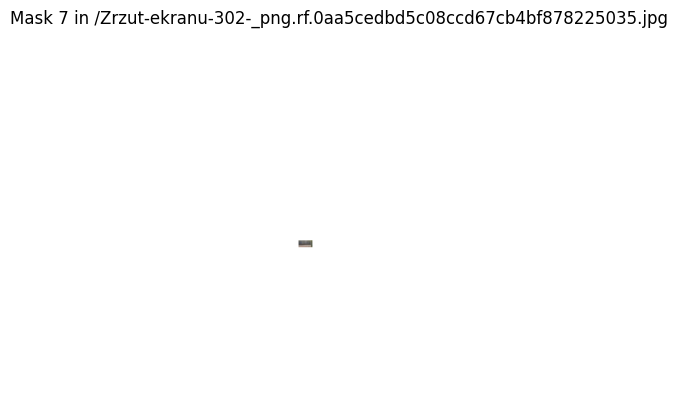

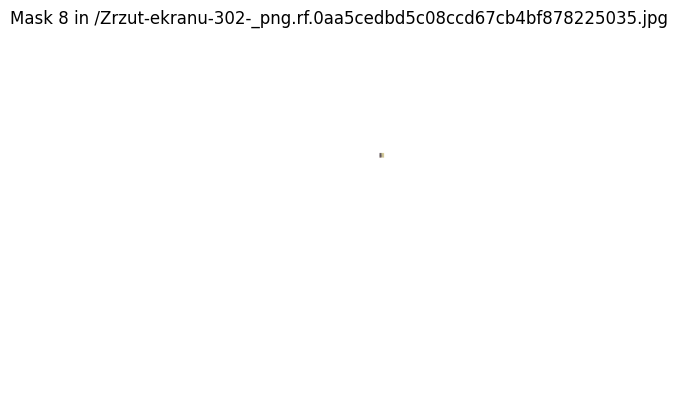

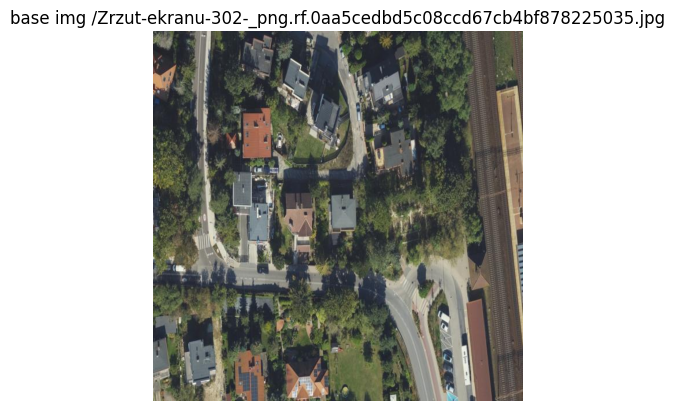

Speed: 1.5ms preprocess, 20.2ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-356-_png.rf.ffc2d6459d5a9d35d2307f5a219c7723.jpg: 640x640 8 solar-panels, 20.1ms
Speed: 1.7ms preprocess, 20.1ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-380-_png.rf.bb8d97d77b6c9885d55ff187b157503d.jpg: 640x640 6 solar-panels, 20.1ms
Speed: 1.3ms preprocess, 20.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-343-_png.rf.585f5b02cba520e1a1dc0e5cdbad0ef5.jpg: 640x640 2 solar-panels, 20.2ms
Speed: 1.3ms preprocess, 20.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_

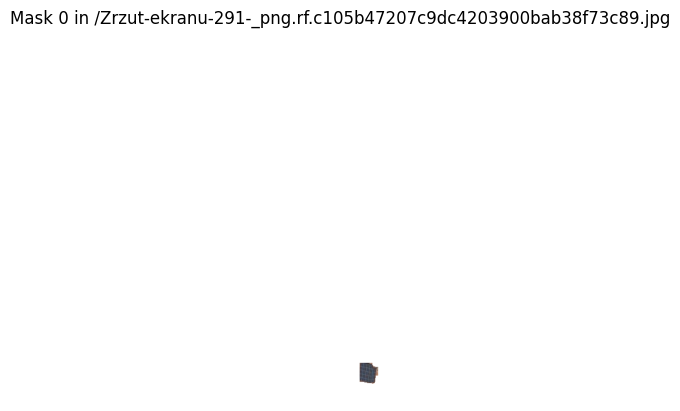

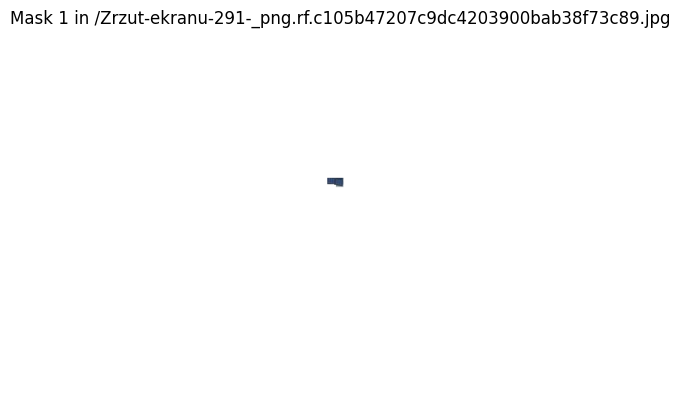

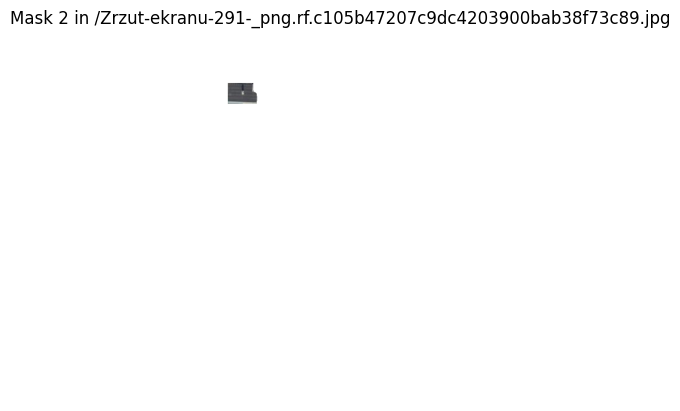

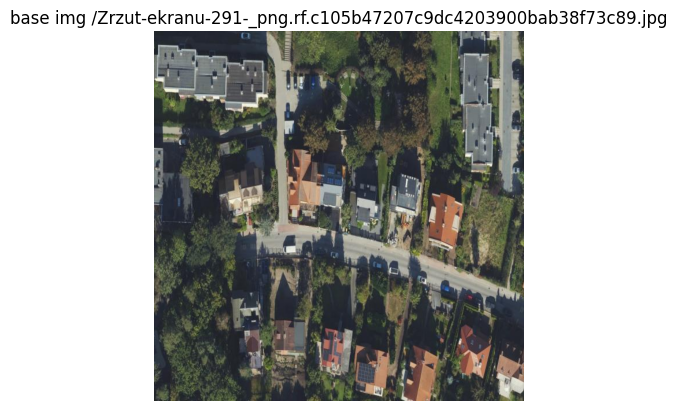

Speed: 1.2ms preprocess, 19.9ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-396-_png.rf.71fe178319502aa30b18d0f5bb2dbbbd.jpg: 640x640 7 solar-panels, 20.2ms
Speed: 1.6ms preprocess, 20.2ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-318-_png.rf.cf61c84eb3ed6e55c182d5fcc846926a.jpg: 640x640 4 solar-panels, 20.2ms
Speed: 1.6ms preprocess, 20.2ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-374-_png.rf.8d9b0bb5c6b038030107a9948abea9ec.jpg: 640x640 5 solar-panels, 20.2ms
Speed: 1.3ms preprocess, 20.2ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_

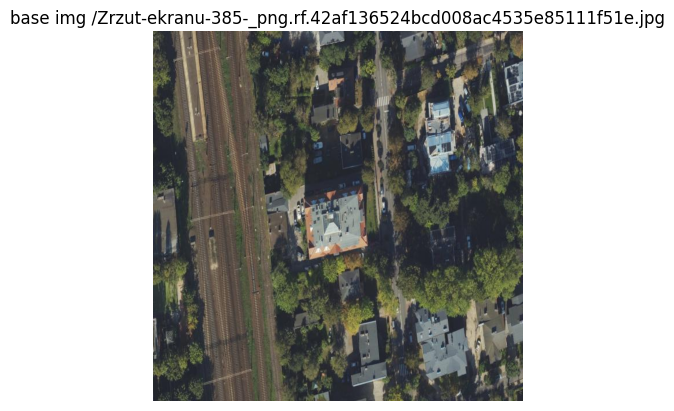

Speed: 1.2ms preprocess, 20.4ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-305-_png.rf.ad24309a90bd6a1544b28f44565261e8.jpg: 640x640 2 solar-panels, 20.2ms
Speed: 1.6ms preprocess, 20.2ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-307-_png.rf.7578455979362fb54af820d2d4ba1cd4.jpg: 640x640 2 solar-panels, 20.1ms
Speed: 1.4ms preprocess, 20.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_panels.v1i.yolov8-obb/test/images/Zrzut-ekranu-365-_png.rf.b37e0e64fa27d5958288bcb8ad16ab45.jpg: 640x640 3 solar-panels, 20.1ms
Speed: 1.2ms preprocess, 20.1ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/marekd6/ZPB/modelling/modelling/pilotPV_

tensor(0.3503, device='cuda:0')

In [43]:
sum_pv_segments_batch('pilotPV_panels.v1i.yolov8-obb/test/images/*.jpg', "pilot_segment", disp_img=True)

## synthetic